# SQL Project, Answering Business Questions

Importing libraries needed

In [1]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import seaborn as sns
%matplotlib inline

First, we create some functions that will optimize the query execution

In [2]:
def run_query(c):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(c, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    query = '''
    SELECT 
        name, 
        type 
    FROM sqlite_master 
    WHERE type IN ("table", "view");
            '''
    return run_query(query)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Genres that sold most tracks

In [6]:
query_1 = '''
WITH track_info AS
(
    SELECT 
        t.genre_id,
        il.track_id, 
        SUM(il.quantity) quantity
    FROM track t
    INNER JOIN invoice_line il
    ON il.track_id = t.track_id
    INNER JOIN invoice i
    ON i.invoice_id = il.invoice_id
    INNER JOIN customer c
    ON c.customer_id = i.customer_id
    WHERE c.country = 'USA'
    GROUP BY t.genre_id, il.track_id
    ORDER BY quantity DESC
)
SELECT 
    g.name Genre, 
    SUM(ti.quantity) Tracks_sold, 
    ROUND(SUM(CAST(ti.quantity AS FLOAT))/CAST((
    SELECT SUM(quantity) FROM track_info
    ) AS FLOAT)*100, 1) Percentage
    FROM track_info ti
    INNER JOIN genre g
    ON g.genre_id = ti.genre_id
    GROUP BY g.name
    ORDER BY 2 DESC
'''
df_genres = run_query(query_1)

In [7]:
df_genres.head()

,Genre,Tracks_sold,Percentage
0,Rock,561,53.4
1,Alternative & Punk,130,12.4
2,Metal,124,11.8
3,R&B/Soul,53,5.0
4,Blues,36,3.4


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



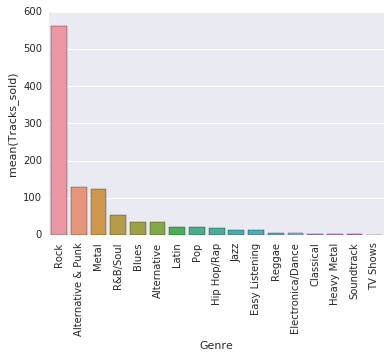

In [8]:
chart = sns.barplot(x='Genre', y='Tracks_sold', data=df_genres)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

## Analysis
As we see, the top 3 most sold genres are pretty similar, but the first have most than 50% of the market

## Sales per Agent

In [9]:
query_2 = '''
SELECT 
    e.hire_date,
    e.first_name || " " || e.last_name Employee,
    SUM(i.total) Sales
FROM customer c
INNER JOIN invoice i
ON i.customer_id = c.customer_id
INNER JOIN employee e
ON e.employee_id = c.support_rep_id
GROUP BY c.support_rep_id
ORDER BY sales DESC
'''
df_employee = run_query(query_2)

In [10]:
df_employee

,hire_date,Employee,Sales
0,2017-04-01 00:00:00,Jane Peacock,1731.51
1,2017-05-03 00:00:00,Margaret Park,1584.00
2,2017-10-17 00:00:00,Steve Johnson,1393.92


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



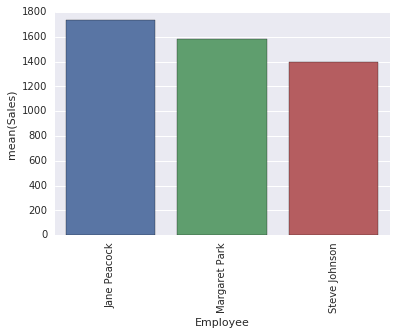

In [11]:
chart = sns.barplot(x='Employee', y='Sales', data=df_employee)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

## Analysis
Taking in acount the hire date we can explain why the order Jane is the first, Margaret the second and Steve the third

## Customers and Sales per Country

In [12]:
#query_3 = '''
#CREATE VIEW countries_sales AS 
#    SELECT 
#        CASE 
#            WHEN COUNT(DISTINCT c.customer_id) == 1 THEN 'Other'
#            ELSE c.country
#        END Countries,
#        COUNT(DISTINCT c.customer_id) Number_Customers,
#        SUM(i.total) Sales,
#        AVG(i.total) Avg_Sales
#    FROM customer c
#    INNER JOIN invoice i
#    ON c.customer_id = i.customer_id
#    GROUP BY c.country
#    ORDER BY 3 DESC;
#'''
#run_command(query_3)

In [13]:
query_4 ='''
SELECT 
    Countries, 
    SUM(Number_Customers) N_Customer, 
    SUM(Sales) Sales,
    AVG(Avg_Sales) Avg_Sales
FROM countries_sales
GROUP BY countries
ORDER BY 2 DESC
'''
df_countries = run_query(query_4)

In [14]:
df_countries

,Countries,N_Customer,Sales,Avg_Sales
0,Other,15,1094.94,7.445071
1,USA,13,1040.49,7.942672
2,Canada,8,535.59,7.047237
3,Brazil,5,427.68,7.011148
4,France,5,389.07,7.781400
5,Germany,4,334.62,8.161463
6,United Kingdom,3,245.52,8.768571
7,Czech Republic,2,273.24,9.108000
8,India,2,183.15,8.721429
9,Portugal,2,185.13,6.383793


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



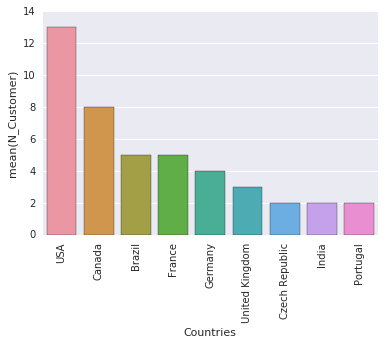

In [15]:
chart = sns.barplot(x='Countries', y='N_Customer', data=df_countries[df_countries['Countries']!='Other'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



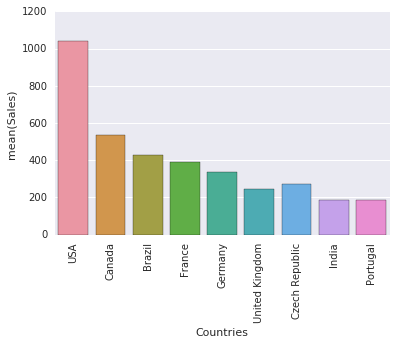

In [16]:
chart = sns.barplot(x='Countries', y='Sales', data=df_countries[df_countries['Countries']!='Other'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



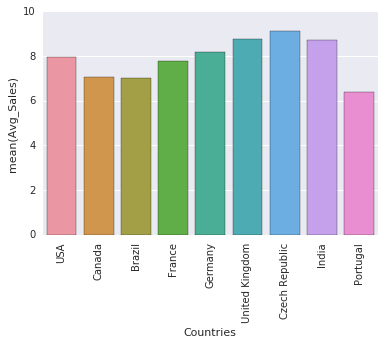

In [17]:
chart = sns.barplot(x='Countries', y='Avg_Sales', data=df_countries[df_countries['Countries']!='Other'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

## Analysis
The USA is the country with most customers and sales, but Czech Republic is the country in wich in average the sales per customer is higer

In [19]:
query_6 ='''
SELECT
    a.album_id,
    a.title,
    t.track_id,
    t.name
FROM album a
INNER JOIN track t
ON a.album_id = t.album_id
'''
run_query(query_6)

,album_id,title,track_id,name
0,1,For Those About To Rock We Salute You,1,For Those About To Rock (We Salute You)
1,2,Balls to the Wall,2,Balls to the Wall
2,3,Restless and Wild,3,Fast As a Shark
3,3,Restless and Wild,4,Restless and Wild
4,3,Restless and Wild,5,Princess of the Dawn
5,1,For Those About To Rock We Salute You,6,Put The Finger On You
6,1,For Those About To Rock We Salute You,7,Let's Get It Up
7,1,For Those About To Rock We Salute You,8,Inject The Venom
8,1,For Those About To Rock We Salute You,9,Snowballed
9,1,For Those About To Rock We Salute You,10,Evil Walks
